In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

## Load the clean BASMI data

This dataset is a pivoted version of the BASMI data, and also contains information about which drug the patient was using at the time.

In [3]:
basmi_df = pd.read_excel('data/clean_basmi.xls', index_col=(0,1)).reset_index()

# Turn the Drug column into binary
basmi_df['Drug_Indicator'] = basmi_df['Drug'].notnull().map({False: 0, True: 1})
basmi_df.drop('Drug',axis=1, inplace=True)

print('Number of patients in basmi dataset:', len(basmi_df['patient_id'].unique()))

basmi_df.head()

Number of patients in basmi dataset: 910


,patient_id,Date,CRS,TWS,LSFS,LFS,IMS,BS,Drug_Indicator
0,40,1995-05-09,3,1,6,5,3,3.6,0
1,40,1995-06-01,3,1,8,5,3,4.0,0
2,40,1995-06-12,2,1,5,3,2,2.6,0
3,40,1995-11-02,1,1,3,4,2,2.2,0
4,40,1996-05-02,2,1,4,3,2,2.4,0


In [4]:
# Demographics DataFrame
demo_df = pd.read_excel('data/demographics and Biologics data.xlsx')

print('Number of patients in demographics data :', len(demo_df['patient_id'].unique()))
print('Shape of the dataset: ',demo_df.shape)
demo_df.head()

Number of patients in demographics data : 721
Shape of the dataset:  (721, 10)


,patient_id,patient_gender_id,patient_date_of_diagnosis,Age at diagnosis,patient_hla_bUnknown7_id,EIBP,patient_condition_subtype,Current biologic,Number of biologics used (not including brand/biosimilar switch),year of Birth
0,40,Female,1994-01-01,46.255989,Positive,False,AS,Infliximab,1,1947
1,41,Male,2003-01-01,46.644764,Positive,False,AS,Adalimumab,1,1956
2,43,Male,1978-01-01,20.410678,Positive,False,AS,Adalimumab,1,1957
3,44,Male,1994-01-01,22.047912,Unknown,False,AS,Adalimumab,1,1971
4,45,Male,1998-01-01,37.048597,Positive,False,AS,Etanercept,1,1960


### Deal with missing values

The dataset has some missing values...Lets remove all rows with any missing values from the dataset..

In [5]:
demo_df.dropna(how='any',inplace=True)
print('Updated shape : ',demo_df.shape)
demo_df.head()

Updated shape :  (679, 10)


,patient_id,patient_gender_id,patient_date_of_diagnosis,Age at diagnosis,patient_hla_bUnknown7_id,EIBP,patient_condition_subtype,Current biologic,Number of biologics used (not including brand/biosimilar switch),year of Birth
0,40,Female,1994-01-01,46.255989,Positive,False,AS,Infliximab,1,1947
1,41,Male,2003-01-01,46.644764,Positive,False,AS,Adalimumab,1,1956
2,43,Male,1978-01-01,20.410678,Positive,False,AS,Adalimumab,1,1957
3,44,Male,1994-01-01,22.047912,Unknown,False,AS,Adalimumab,1,1971
4,45,Male,1998-01-01,37.048597,Positive,False,AS,Etanercept,1,1960


### Descriptive Stats

Now, lets look at some descriptive statistics.

#### Age distribution

First, lets take a look at the age distribution. Because age naturally changes over time, we will use the age at first diagnosis - ie the age at which the patient entered the study. 

Text(0,0.5,'Prob')

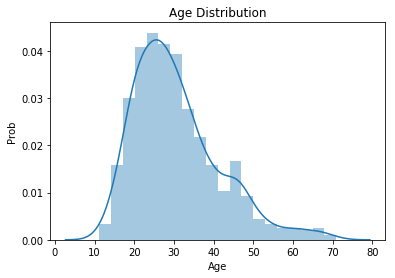

In [6]:
age_at_entry = demo_df['Age at diagnosis'].values

ax = sns.distplot(age_at_entry )
ax.set_title('Age Distribution')
ax.set_xlabel('Age')
ax.set_ylabel('Prob')

#### Gender

Lets look at the gender distribution and also some basic stats on the BASMI score for each gender group

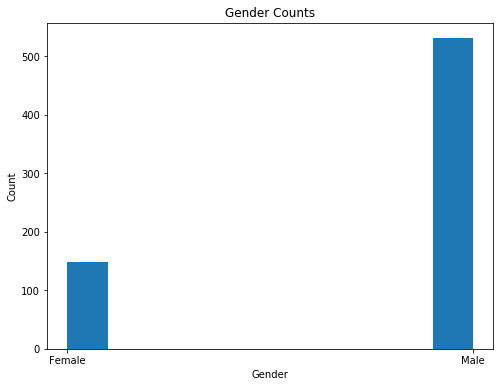

In [7]:
genders = demo_df['patient_gender_id']

# First plot the distribution
fig = plt.figure(figsize=(8,6))
plt.hist(genders)
plt.title('Gender Counts')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [8]:
# # Get some stats about male and female patients
# male_ids = demo_df[genders == 'Male']['patient_id']
# female_ids = demo_df[genders == 'Female']['patient_id']


# # Most probably not the best way to do this, but whatever
# male_basmi_df = basmi_df[basmi_df['patient_id'].isin(male_ids)]
# female_basmi_df = basmi_df[basmi_df['patient_id'].isin(female_ids)]

# # Get the average BS score for each male patient
# # TODO - Check the averaging method with LUCA
# avg_male_bs_df = male_basmi_df.groupby(male_basmi_df['patient_id']).agg({'BS': 'mean'})
# avg_female_bs_df = female_basmi_df.groupby(female_basmi_df['patient_id']).agg({'BS': 'mean'})

# # # Now get the average BS score over all male and female patients
# print('Male BS Score Information:\n')
# print(avg_male_bs_df.describe())

# print('\n\nFemale BS Score Information:\n')
# print(avg_female_bs_df.describe())

## BS Score Over Time

#### 1. Normalize the patient timeline to be 0 at the time they joined the study. 

In [9]:
import numpy as np
# Get the number of years a patient has been in the study
dfs = []
ids = []
for patient_id, patient_series in basmi_df.groupby('patient_id'):
    
    dates = patient_series['Date']
    start_date = dates.iloc[0]
    
    years = []
    for date in dates:
        # Number of days since patient joined study
        num_days = pd.Timedelta(date - start_date).days
        # Number of years since patient joined study
        num_years = int(num_days/365)
        
        years.append(num_years)
    
    df = pd.DataFrame(years,columns=['years'])
    df['id'] = patient_id
    
    dfs.append(df)
    
years_df = pd.concat(years_dfs)
print(basmi_df.shape)
print(years_df.shape)

new_df = basmi_df.copy()
new_df['years'] = years_df['years']

new_df[new_df['patient_id'] == 370]

NameError: name 'years_dfs' is not defined

#### 2. Bin data per year for each patient

If patient has multiple measurements within a year, take the mean of those measurements.

Now each patient should have one score per year in study.

In [91]:
# BS data aggregated by patient for each year in study
agg_bs_df = basmi_df.groupby(['patient_id','years_in_study']).agg({'BS': 'mean'}).reset_index()
agg_bs_df = agg_bs_df.round(2)
agg_bs_df.head()

,patient_id,years_in_study,BS
0,40,0,2.96
1,40,1,3.00
2,40,2,3.20
3,40,3,3.10
4,40,4,3.40


#### 3. Impute the missing values
If a patient missed a year, impute the missing value by assuming a linear progression

To get the progression rate, use the difference between BS scores before and after missing values and divide by the time difference.


In [99]:
fixed_dfs = []
for patient_id, patient_series in agg_bs_df.groupby('patient_id'):
    
    print(patient_id)
    
    years = patient_series['years_in_study']
    
    bs_scores = patient_series['BS'] 

    rate_of_change = (bs_scores.shift(-1) - bs_scores) / (years.shift(-1) - years)
    
    bs_scores.index = years
    rate_of_change.index = years

    # Full range of years - the actual years that patient was in the study
    years_range = pd.RangeIndex(start=years.iloc[0], stop=years.iloc[-1])
    
    fixed_data = []
    last_bs_obs = None
    for year in years_range:
        # If we had data for this year, add set the last observation
        # and add this entry to fixed data
        if year in years.values:
            last_obs = (bs_scores.loc[year], rate_of_change.loc[year])
            fixed_data.append(last_obs[0])
            
        # Else, make a new observation by adding the rate of change to the last BS score we had
        # and updating the last observation to this new observation keeping the rate of change the same
        else:
            new_obs = last_obs[0] + last_obs[1]
            fixed_data.append(new_obs)
            last_obs = (new_obs, last_obs[1])
    
    fixed_df = pd.DataFrame({'BS': fixed_data, 'years_in_study': years_range})
    fixed_df['patient_id'] = patient_id
    
    if fixed_df.shape[0] == 0:
        print(patient_series)
        break
    
    fixed_dfs.append(fixed_df)
    
    
print(len(fixed_dfs))
    
fixed_bs_df = pd.concat(fixed_dfs)

fixed_bs_df

40
41
43
44
45
46
47
50
51
52
53
54
55
57
59
60
61
63
65
67
68
69
70
71
72
73
75
76
78
79
80
81
82
83
84
85
86
87
88
89
90
92
93
95
96
98
99
100
101
102
103
104
105
108
110
111
112
114
115
118
119
120
121
122
124
125
127
128
129
130
131
132
134
135
136
138
139
140
141
142
143
144
145
147
148
149
150
151
152
154
155
156
157
162
163
165
171
173
174
175
176
177
178
179
181
184
185
186
187
188
191
192
193
194
195
196
197
199
200
206
208
210
211
212
218
219
221
222
223
224
225
226
227
231
233
235
236
237
238
239
240
242
243
244
245
246
247
249
254
256
257
261
262
264
266
269
270
271
272
273
274
275
276
277
278
279
282
284
286
287
288
289
296
297
299
300
301
303
304
305
306
308
309
311
313
315
319
320
321
322
324
325
326
327
328
329
330
336
339
342
343
345
347
348
353
357
358
359
360
361
362
363
366
368
370
371
373
374
379
381
382
383
384
385
386
387
390
392
393
394
395
396
398
399
401
402
403
404
405
406
407
408
410
411
412
414
415
416
417
418
419
421
422
423
424
426
430
433
434
435
436
437

,BS,years_in_study,patient_id
0,2.960000,0,40
1,3.000000,1,40
2,3.200000,2,40
3,3.100000,3,40
4,3.400000,4,40
5,3.100000,5,40
6,3.600000,6,40
7,3.500000,7,40
8,3.000000,8,40
9,2.800000,9,40


In [93]:
patients = fixed_bs_df['patient_id']

print('number of patients = ',len(patients.unique()))

number of patients =  798


In [61]:
# BS score aggregated over all patients for each year in study
agg_bs_yearly = agg_bs_df.groupby(level=1).agg({'BS': 'mean'})

# Number of patients that stayed this long in the study
patient_count_per_year = agg_bs_df.groupby(level=1).apply(len)

patient_count_per_year

years_in_study
0     751
1     726
2     707
3     687
4     672
5     641
6     624
7     596
8     573
9     545
10    520
11    488
12    462
13    442
14    413
15    386
16    340
17    320
18    288
19    261
20    219
21    182
22    150
23    127
24    117
25    102
26     89
27     76
28     57
29     40
30     32
31     14
32      3
33      3
34      3
35      2
36      2
37      2
38      1
39      1
40      1
dtype: int64